# Multi-Task Learning (MTL) Basics Tutorial

Multi-task learning is increasingly becoming a standard tool for the modern ML practioner. A major requirement of this regime is the ability to easily *add or remove new datasets, new label sets, new tasks, and new metrics*. Thus, in the Snorkel multi-task model design, each of these concepts have been decoupled. 

The purpose of this tutorial is to introduce the basic classes and flow of the multi-task learning tools within Snorkel (not necessarily to motivate or explain multi-task learning at large; we assume prior experience with MTL). For a broader understanding of the general Snorkel pipeline and library, see the tutorials under `tutorials/workshop/`. 

In this notebook, we'll look at a simple MTL model with only two tasks, each having distinct data and only one set of labels (the ground truth or "gold" labels). We'll also use data where the raw data is directly usable as features, for simplicity (i.e., unlike text data, where we would first need to tokenize and transform the data into token ids).

## Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

SEED = 123

## Create Toy Data

We'll now create a toy dataset to work with.
Our data points are 2D points in a square centered on the origin.
Our tasks will be classifying whether these points are:

1. Inside a **unit circle** centered on the origin
2. Inside a **unit square** centered on the origin

We'll visualize these decision boundaries in a few cells.

In [2]:
import torch
torch.manual_seed(SEED)

N = 500  # Data points per dataset
R = 1    # Unit distance

# Dataset 0 ("circle")
circle_data = torch.rand(N, 2) * 2 - 1
circle_labels = (circle_data[:,0]**2 + circle_data[:,1]**2 < R).long()

# Dataset 1 ("square")
square_data = torch.rand(N, 2) * 2 - 1
square_labels = (
    (-0.5 < square_data[:,0]) 
    * (square_data[:,0] < 0.5) 
    * (-0.5 < square_data[:,1]) 
    * (square_data[:,1] < 0.5)
).long()

Note that, as is the case throughout the Snorkel repo, the **label 0 is reserved for abstaining/no label**; all actual labels have values greater than 0. This provides flexibility for supervision sources to label only portions of a dataset, for example. Thus, we'll convert our labels from being (1 = positive, 0 = negative) to (0=abstain, 1 = positive, 2 = negative).

In [3]:
from snorkel.analysis.utils import convert_labels

circle_labels = convert_labels(circle_labels, "onezero", "categorical")
square_labels = convert_labels(square_labels, "onezero", "categorical")

And we can view the ground truth labels of our tasks visually to confirm our intuition on what the decision boundaries look like.

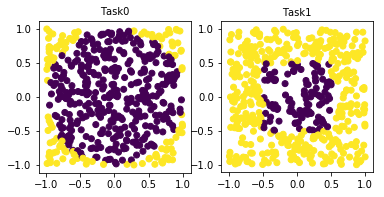

In [4]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)

axs[0].scatter(circle_data[:,0], circle_data[:,1], c=circle_labels)
axs[0].set_aspect('equal', 'box')
axs[0].set_title('Task0', fontsize=10)

axs[1].scatter(square_data[:,0], square_data[:,1], c=square_labels)
axs[1].set_aspect('equal', 'box')
axs[1].set_title('Task1', fontsize=10)

plt.show()

We'll now divide this synthetic data into train/valid/test splits using our helper function `split_data()`.

In [5]:
from snorkel.end_model.data import split_data

circle_data_splits, circle_label_splits = split_data(
    circle_data, circle_labels, splits=[0.8, 0.1, 0.1], seed=SEED
)

square_data_splits, square_label_splits = split_data(
    square_data, square_labels, splits=[0.8, 0.1, 0.1], seed=SEED
)

## Make DataLoaders

With our data now loaded/created, we can now package it up into `MultitaskDataLoader`s for training. 

In the `MultitaskDataLoader`, we specify a mapping from each `Task` to its corresponding labels.  We'll define these `Task` objects in the following section as we define our model.

In [6]:
from snorkel.mtl.data import MultitaskDataset, MultitaskDataLoader

dataloaders = []
for split in [0,1,2]:
    X_dict = {"circle_data": circle_data_splits[split]}
    Y_dict = {"circle_labels": circle_label_splits[split]}
    dataset = MultitaskDataset("Circle", X_dict, Y_dict)

    task_to_label_dict = {"circle_task": "circle_labels"}

    dataloader = MultitaskDataLoader(
        task_to_label_dict,
        dataset,
        split=["train", "valid", "test"][split],
        batch_size=32,
    )
    dataloaders.append(dataloader)
    
for split in [0,1,2]:
    X_dict = {"square_data": square_data_splits[split]}
    Y_dict = {"square_labels": square_label_splits[split]}
    dataset = MultitaskDataset("Square", X_dict, Y_dict)

    task_to_label_dict = {"square_task": "square_labels"}

    dataloader = MultitaskDataLoader(
        task_to_label_dict,
        dataset,
        split=["train", "valid", "test"][split],
        batch_size=32,
    )
    dataloaders.append(dataloader)

## Define Model

Now we'll define the `MultitaskModel`, which is build from a list of `Tasks`.

### Tasks

A `Task` represents a path through a network. In Snorkel, this corresponds to a particular sequence of PyTorch modules that each `DataPoint` will pass through. 

To specify this sequence of modules, each `Task` defines a **module pool** (a set of modules that it relies on) and a **task flow**—a sequence of `Operation`s. Each `Operation` defines a module and the inputs to feed to that module. These inputs are described with a list of tuples, where each tuple is either (`_input_`, \[field_name\]), or the name of a previous operation and the index of its output to use (most modules have only a single output, so the second element of these tuples is almost always 0).

For example, below we define the module pool and task flow for the circle task:

In [7]:
import torch.nn as nn
from snorkel.mtl.task import Task, Operation

# Define a two-layer "input" module and a one-layer prediction "head" module
input_module = nn.Sequential(nn.Linear(2, 8), nn.ReLU(), nn.Linear(8, 4), nn.ReLU())
head_module = nn.Linear(4, 2)

# The module pool contains all the modules this task uses
module_pool = nn.ModuleDict(
    {
        "input_module": input_module,
        "circle_head_module": head_module,
    }
)

# "From the input dictionary, pull out 'circle_data' and send it through input_module"
op1 = Operation(
    name="input_op",
    module_name="input_module",
    inputs=[("_input_", "circle_data")] 
)

# "From the output of op1 (the input op), pull out the 0th indexed output
# (i.e., the only output) and send it through the head_module"
op2 = Operation(
    name="head_op",
    module_name="circle_head_module",
    inputs=[("input_op", 0)]
)

task_flow = [op1, op2]

The output of the final module in that sequence will then go into a `loss_func()` to calculate the loss (e.g., cross-entropy) during training or an `output_func()` (e.g., softmax) to convert the logits into a prediction.  Each `Task` also specifies which metrics it supports, which are bundled together in a `Scorer` object. For this tutorial, we'll just look at accuracy.

Putting this all together, we define the circle task:

In [8]:
from functools import partial

from snorkel.mtl.task import Task
from snorkel.mtl.scorer import Scorer
from snorkel.mtl.modules.utils import ce_loss, softmax

circle_task = Task(
    name="circle_task",
    module_pool=module_pool,
    task_flow=task_flow,
    loss_func=partial(ce_loss, "head_op"),
    output_func=partial(softmax, "head_op"),
    scorer = Scorer(metrics=["accuracy"])
)

Note that `Task` objects are not dependent on a particular dataset; multiple datasets can be passed through the same modules for pre-training or co-training.

We'll now define the square task, but more succinctly—for example, using the fact that the default name for an `Operation` is its `module_name` (since most tasks only use their modules once per forward pass). We'll also define the square task to share the input module with the circle task to demonstrate how to share modules. (Note that this is purely for illustrative purposes; for this toy task, it is very possible that this is not the optimal arrangement of modules).

In [9]:
square_task = Task(
    name="square_task",
    module_pool=nn.ModuleDict({
        "input_module": input_module, 
        "square_head": nn.Linear(4, 2)
    }),
    task_flow = [
        Operation("input_module", [("_input_", "square_data")]),
        Operation("square_head", [("input_module", 0)])
    ],
    loss_func=partial(ce_loss, "square_head"),
    output_func=partial(softmax, "square_head"),
    scorer = Scorer(metrics=["accuracy"])
)   

## Model

With our tasks defined, constructing a model is simple: we simply pass the list of tasks in and the model constructs itself using information from the task flows.

In [10]:
from snorkel.mtl.model import MultitaskModel

model = MultitaskModel([circle_task, square_task])

### Train Model

Once the model is constructed, we can train it as we would a single-task model, using the `train_model` method of a `Trainer` object. The `Trainer` supports multiple schedules or patterns for sampling from different dataloaders; the default is to randomly sample from them proportional to their number of batches, such that all `DataPoints` will be seen exactly once before any are seen twice.

In [11]:
from snorkel.mtl.trainer import Trainer

trainer_config = {
    "progress_bar": True,
    "n_epochs": 10,
    "lr": 0.02,
    "counter_units": "epochs",
    "evaluation_freq": 2.0,
}

trainer = Trainer(**trainer_config)
trainer.train_model(model, dataloaders)

Epoch 9:: 100%|██████████| 26/26 [00:00<00:00, 297.55it/s, square_task/Square/train/loss=0.152, model/all/train/loss=0.212, model/all/train/lr=0.02, circle_task/Circle/train/loss=0.273, circle_task/Circle/valid/accuracy=0.86, square_task/Square/valid/accuracy=0.96]


### Evaluate model

After training, we can call the model.score() method to see the final performance of our trained model.

In [12]:
model.score(dataloaders)

{'circle_task/Circle/train/accuracy': 0.875,
 'circle_task/Circle/valid/accuracy': 0.86,
 'circle_task/Circle/test/accuracy': 0.82,
 'square_task/Square/train/accuracy': 0.9525,
 'square_task/Square/valid/accuracy': 0.96,
 'square_task/Square/test/accuracy': 0.98}

Task-specific metrics are recorded in the form `task/dataset/split/metric` corresponding to the task the made the predictions, the dataset the predictions were made on, the split being evaluated, and the metric being calculated.

For model-wide metrics (such as the total loss over all tasks or the learning rate), the default task name is `model` and the dataset name is "all".

## Summary

In this tutorial, we demonstrated how to specify arbitrary flows through a network with  multiple datasets, providing the flexiblity to easily implement design patterns such as multi-task learning. On this toy task with only two simple datasets and very simple hard parameter sharing (a shared trunk with different heads), the utility of this design may be less apparent. However, for more complicated network structures (e.g., slicing) or scenarios with frequent changing of the structure (e.g., due to popping new tasks on/off a massive MTL model), the flexibility of this design starts to shine. If there's an MTL network you'd like to build but can't figure out how to represent, post an issue and let us know!